Refining data cleaning and processing skills to create a AAPL volatility index based on the calculations of the VIX

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [31]:
# loading options data
options_df = pd.read_csv("AAPL_options.csv")
# cleaning
options_df[options_df["bid price"] >= 0]

# correct expiration dates for 30 day VIX
T = (pd.to_datetime(options_df["expiration date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["days to expiration"] = T

# creating moneyness, spread columns
options_df["moneyness"] = round(options_df["closing price"] - options_df["strike price"], 5)
options_df["spread"] = round(options_df["ask price"] - options_df["bid price"], 5) 

# creating mid price
options_df["mid price"] = round((options_df["ask price"] + options_df["bid price"])/2, 5)

# concatenating call and put rows for the same price    
options_df["call mid"] = 0
options_df["put mid"] = 0
options_df["call spread"] = 0
options_df["put spread"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
options_df.iloc[indices[call_mask], 19] = options_df.iloc[indices[call_mask], 18].values
options_df.iloc[indices[call_mask], 20] = options_df.iloc[indices[call_mask] + 1, 18].values
options_df.iloc[indices[call_mask], 21] = options_df.iloc[indices[call_mask], 17].values
options_df.iloc[indices[call_mask], 22] = options_df.iloc[indices[call_mask] + 1, 17].values

# assign values based on put options
options_df.iloc[indices[put_mask], 20] = options_df.iloc[indices[put_mask], 18].values
options_df.iloc[indices[put_mask], 19] = options_df.iloc[indices[put_mask] + 1, 18].values
options_df.iloc[indices[put_mask], 22] = options_df.iloc[indices[put_mask], 17].values
options_df.iloc[indices[put_mask], 21] = options_df.iloc[indices[put_mask] + 1, 17].values

# days to expiration greater than 20 and less than 33 
mask1 = options_df["days to expiration"] > 20
mask2 = options_df["days to expiration"] < 33
options_df = options_df[mask1]
options_df = options_df[mask2]

# creating call put diff column
options_df["call put diff"] = round(options_df["call mid"] - options_df["put mid"], 5)

options_df.head(2)

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_2156\1836972698.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  options_df = options_df[mask2]
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_2156\1836972698.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_df["call put diff"] = round(options_df["call mid"] - options_df["put mid"], 5)


,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,...,exp date div,days to expiration,moneyness,spread,mid price,call mid,put mid,call spread,put spread,call put diff
464,2016-01-04,2016-01-29,put,17.5,0.0300,1356.0,0.0025,2176.0,0.0325,80.0,...,0.123607,25,8.837,0.0275,0.01625,8.825,0.01625,0.175,0.0275,8.80875
465,2016-01-04,2016-01-29,call,17.5,8.9125,76.0,8.7375,92.0,8.2000,8.0,...,0.123607,25,8.837,0.1750,8.82500,0.000,0.00000,0.000,0.0000,0.00000


In [32]:
# reducing rows to every other
options_df = options_df[options_df.index % 2 == 0]
# rearranging index
options_df.index = np.arange(0, len(options_df))
options_df.head()
options_df = options_df.drop(["bid price", "ask price", "last price",
"volume", "open interest", "exp closing price", "date div", "exp date div","type"], axis=1)

In [33]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["days to expiration", "strike price", "closing price", "moneyness",
 "spread", "call mid", "put mid", "call spread", "put spread", "call put diff"]:
    df[header] = options_df.groupby("date")[header].apply(list)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
    
df.head(2)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,call put diff
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...","[8.80875, 7.57375, 6.31625, 5.05, 3.80625, 2.5..."
1,2016-01-05,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[8.177, 6.927, 5.677, 4.427, 3.177, 1.927, 0.6...","[0.015, 0.0075, 0.01, 0.015, 0.01, 0.02, 0.02,...","[8.21875, 6.975, 5.75625, 4.5375, 3.36875, 2.2...","[0.0175, 0.02875, 0.0525, 0.095, 0.175, 0.35, ...","[0.0875, 0.075, 0.0875, 0.075, 0.0625, 0.0625,...","[0.015, 0.0075, 0.01, 0.015, 0.01, 0.02, 0.02,...","[8.20125, 6.94625, 5.70375, 4.4425, 3.19375, 1..."


In [34]:
# i have no clue why row 42 is weird i dropped the row on rates too
df = df.drop(42)
df_index = np.arange(df.shape[0])
df.index = df_index


In [35]:
# importing rates data
mo1 = pd.read_csv("1Month_2016.csv")
mo3 = pd.read_csv("3Month_2016.csv")
mo6 = pd.read_csv("6Month_2016.csv")
yr1 = pd.read_csv("1Year_2016.csv")

# combining data and dropping duplicate date columns
rates = pd.concat([mo1, mo3, mo6, yr1], axis=1)
# df.columns.duplicated returns True for duplicated columns (for columns [a, b, a]: [False, False, True])
# ~ inverts ([True, True, False]) so it only keeps non duplicates 
rates = rates.loc[:,~rates.columns.duplicated()]

#  renaming columns and filling na 
rates = rates.rename(columns={"DGS1MO":"1MO","DGS3MO":"3MO","DGS6MO":"6MO","DGS1":"1YR"})
rates = rates.replace(".", np.NaN).dropna()
rates["DATE"] = pd.to_datetime(rates["DATE"])
rates = rates.drop(42)
# date to datetime
rates_index = np.arange(rates.shape[0])
rates.index = rates_index

In [36]:
# creating cubic spline based on rates 
df["terms"] = df["days to expiration"].apply(lambda x:
sorted(set(x)))

# model 
from scipy.interpolate import CubicSpline

rates["terms"] = df["terms"]
rates["interpolated"] = None

def interpolation(row):
    y = list(row[["1MO", "3MO", "6MO", "1YR"]])
    x = [30, 90, 180, 365]
    cs = CubicSpline(x, y)
    xs = row["terms"]
    res = [np.round(cs(x_val), 3) for x_val in xs]
    return res

rates["interpolated"] = rates.apply(interpolation, axis=1)
rates.head()

,DATE,1MO,3MO,6MO,1YR,terms,interpolated
0,2016-01-04,0.17,0.22,0.49,0.61,"[25, 32]","[0.174, 0.169]"
1,2016-01-05,0.20,0.20,0.49,0.68,"[24, 31]","[0.214, 0.198]"
2,2016-01-06,0.21,0.21,0.47,0.67,"[23, 30]","[0.225, 0.21]"
3,2016-01-07,0.20,0.20,0.46,0.66,"[22, 29]","[0.217, 0.202]"
4,2016-01-08,0.20,0.20,0.45,0.64,"[21, 28]","[0.219, 0.204]"


In [37]:
# finding the forward level
# for each row: find the min abs of the call put diff for each term
# take this index and find the strike price for each term
# F = k + e^(cubic spline for CMT)(days to expiration / 365) for both near term and next term

# near_term = terms_arr[near_term_mask]

def near_term_mask(row):
    arr = np.array(row)
    return list(arr < 26)

df["near term"] = df["days to expiration"].apply(near_term_mask)
df["next term"] = df["near term"].apply(lambda x: [~val for val in x])

df["abs call put diff"] = df["call put diff"].apply(lambda x:[np.abs(i) for i in x])

def min_index(row, mask):
    mask = np.array(mask)
    near = np.array(row)[mask]
    try:
        return list(row).index(min(list(near)))
    except:
        return 404

df["near min id"] = df.apply(lambda x: min_index(x["abs call put diff"], x["near term"]), axis=1)
df["next min id"] = df.apply(lambda x: min_index(x["abs call put diff"], x["next term"]), axis=1)
    
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,call put diff,terms,near term,next term,abs call put diff,near min id,next min id
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...","[8.80875, 7.57375, 6.31625, 5.05, 3.80625, 2.5...","[25, 32]","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[8.80875, 7.57375, 6.31625, 5.05, 3.80625, 2.5...",11,56


In [38]:
# applying near and next term masks to strike prices
def masking(arr, mask):
    arr = np.array(arr)
    mask = np.array(mask)
    return arr[mask]

df["near strike prices"] = list(map(masking, df["strike price"], df["near term"]))
df["next strike prices"] = list(map(masking, df["strike price"], df["next term"]))

# finding the near and next term forward price
df["interpolated"] = rates["interpolated"]

def min_diff_strike(col, idx):
    return np.array(col)[idx]

df["k_near"] = list(map(min_diff_strike, df["strike price"], df["near min id"]))
df["k_next"] = list(map(min_diff_strike, df["strike price"], df["next min id"]))

df["r_near"] = np.array([row[0] for row in df["interpolated"]])
df["r_next"] = np.array([row[1] for row in df["interpolated"]])

df["t_near"] = np.array([row[0] for row in df["terms"]]) / 365
df["t_next"] = np.array([row[1] for row in df["terms"]]) / 365

df["near F"] =  round(df["k_near"] + np.exp(df["r_near"] * df["t_near"]), 5)
df["next F"] =  round(df["k_next"] + np.exp(df["r_next"] * df["t_next"]), 5)

df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,next strike prices,interpolated,k_near,k_next,r_near,r_next,t_near,t_next,near F,next F
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,"[20.0, 21.25, 22.5, 23.75, 24.25, 24.375, 24.5...","[0.174, 0.169]",26.25,26.25,0.174,0.169,0.068493,0.087671,27.26199,27.26493


In [42]:
# finding the smallest value under the forward strike
def strike_under_f(col, upr, mask):
    mask = np.array(mask)
    term = np.array(col)[mask]
    return np.max(term[term < upr])

df["near K_0"] = df.apply(lambda x: strike_under_f(x["strike price"], x["near F"], x["near term"]), axis=1)
df["next K_0"] = df.apply(lambda x: strike_under_f(x["strike price"], x["next F"], x["next term"]), axis=1)
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,r_near,r_next,t_near,t_next,near F,next F,near strike,next strike,near K_0,next K_0
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,0.174,0.169,0.068493,0.087671,27.26199,27.26493,27.25,27.25,27.25,27.25


In [43]:
from numba import njit

# finding delta k (average difference between neighbor strikes)
def delta_k(arr):
    res = [0] * len(arr)
    for i in range(len(arr)):
        if i == 0:
            res[i] = arr[1] - arr[0] 
        elif i == (len(arr) - 1):
            res[i] = arr[i] - arr[i - 1]
        else:
            res[i] = (arr[i+1] - arr[i-1])/2
    return res

df["near delta K"] = list(map(delta_k, df["near strike prices"]))
df["next delta K"] = list(map(delta_k, df["next strike prices"]))

df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,t_near,t_next,near F,next F,near strike,next strike,near K_0,next K_0,near delta K,next delta K
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,0.068493,0.087671,27.26199,27.26493,27.25,27.25,27.25,27.25,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 0.75, 0.2...","[1.25, 1.25, 1.25, 0.875, 0.3125, 0.125, 0.125..."


In [45]:
# making near and next call and put mid price columns
df["near call mid"] = list(map(masking, df["call mid"], df["near term"]))
df["near put mid"] = list(map(masking, df["put mid"], df["near term"]))

df["next call mid"] = list(map(masking, df["call mid"], df["next term"]))
df["next put mid"] = list(map(masking, df["put mid"], df["next term"]))

In [52]:
# creating list of otm prices Q(K)
def combined_otms(strikes, call, put, K_0):
    res = []
    for i in range(len(strikes)):
        if strikes[i] < K_0:
            res.append(put[i])
        elif strikes[i] == K_0:
            res.append((put[i] + call[i])/2)
        elif strikes[i] > K_0:
            res.append(call[i])
    return res

df["near otm mid prices"] = list(map(combined_otms, df["near strike prices"],
    df["near call mid"], df["near put mid"], df["near K_0"]))

df["next otm mid prices"] = list(map(combined_otms, df["next strike prices"],
    df["next call mid"], df["next put mid"], df["next K_0"]))

#print(df["next otm mid prices"][0])
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,near K_0,next K_0,near delta K,next delta K,near call mid,near put mid,next call mid,next put mid,near otm mid prices,next otm mid prices
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,27.25,27.25,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 0.75, 0.2...","[1.25, 1.25, 1.25, 0.875, 0.3125, 0.125, 0.125...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[6.4, 5.1875, 4.0, 2.875, 2.4625, 2.3625, 2.26...","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,..."


In [67]:
# summation
def summation_func(delta_K, Q, K_i):
    return sum(np.array(delta_K) * np.array(Q) / np.array(K_i) ** 2)

df["near summation"] = list(map(summation_func, df["near delta K"],
                                 df["near otm mid prices"], df["near strike prices"]))
df["next summation"] = list(map(summation_func, df["next delta K"],
                                 df["next otm mid prices"], df["next strike prices"]))

df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,near delta K,next delta K,near call mid,near put mid,next call mid,next put mid,near otm mid prices,next otm mid prices,near summation,next summation
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 0.75, 0.2...","[1.25, 1.25, 1.25, 0.875, 0.3125, 0.125, 0.125...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[6.4, 5.1875, 4.0, 2.875, 2.4625, 2.3625, 2.26...","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...",0.005926,0.006669


In [69]:
# first term
df["near first term"] = (2 / df["t_near"]) * df["near summation"] * np.exp(df["r_near"] * df["t_near"])
df["next first term"] = (2 / df["t_next"]) * df["next summation"] * np.exp(df["r_next"] * df["t_next"])
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,near call mid,near put mid,next call mid,next put mid,near otm mid prices,next otm mid prices,near summation,next summation,near first term,next first term
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,"[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[6.4, 5.1875, 4.0, 2.875, 2.4625, 2.3625, 2.26...","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...",0.005926,0.006669,0.175122,0.154418


In [71]:
# calculating variance for each term
df["near variance"] = df["near first term"] - (1 / df["t_near"]) * ((df["near F"] / df["near K_0"]) - 1) ** 2
df["next variance"] = df["next first term"] - (1 / df["t_next"]) * ((df["next F"] / df["next K_0"]) - 1) ** 2
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,next call mid,next put mid,near otm mid prices,next otm mid prices,near summation,next summation,near first term,next first term,near variance,next variance
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,"[6.4, 5.1875, 4.0, 2.875, 2.4625, 2.3625, 2.26...","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...",0.005926,0.006669,0.175122,0.154418,0.175119,0.154415


In [73]:
# breaking up final calculation into easy readable variables
# time * variance = tv_near or tv_next, time in min = min_near or min_next, random term = min_term
n365, n30 = 525600, 43200 

tv_near = df["near variance"] * df["t_near"]
tv_next = df["next variance"] * df["t_next"]

min_near = (df["t_next"] * n365 - n30) / (df["t_next"] * n365 - df["t_near"] * n365)
min_next = (n30 - df["t_near"] * n365) / (df["t_next"] * n365 - df["t_near"] * n365)

min_term = n365 / n30

df["VIX"] = 100 * np.sqrt(tv_near * min_near + tv_next * min_next * min_term)
df.head(1)

,date,days to expiration,strike price,closing price,moneyness,spread,call mid,put mid,call spread,put spread,...,next put mid,near otm mid prices,next otm mid prices,near summation,next summation,near first term,next first term,near variance,next variance,VIX
0,2016-01-04,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[8.837, 7.587, 6.337, 5.087, 3.837, 2.587, 1.3...","[0.0275, 0.01, 0.0225, 0.025, 0.175, 0.0175, 0...","[8.825, 7.60625, 6.375, 5.1375, 3.9375, 2.8, 1...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.175, 0.1625, 0.15, 0.15, 0.175, 0.15, 0.05,...","[0.0275, 0.01, 0.0225, 0.025, 0.0125, 0.0175, ...",...,"[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...","[0.01625, 0.0325, 0.05875, 0.0875, 0.13125, 0....","[0.0625, 0.09875, 0.17, 0.31125, 0.4025, 0.43,...",0.005926,0.006669,0.175122,0.154418,0.175119,0.154415,34.796004


<AxesSubplot:>

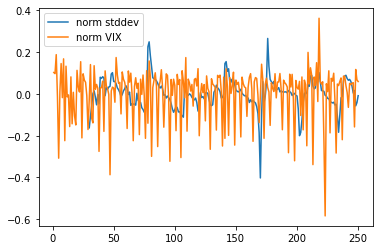

In [91]:
# plotting compared to other measures of volatility
df["stddev"] = df["closing price"].rolling(30).std()
df["norm stddev"] = np.log(df["stddev"] / df["stddev"].shift(1))
df["norm VIX"] = np.log(df["VIX"] / df["VIX"].shift(1))
#df["closing price"] = df["closing price"].apply(lambda x: x[0])
df.tail()
df[["norm stddev", "norm VIX"]].plot()

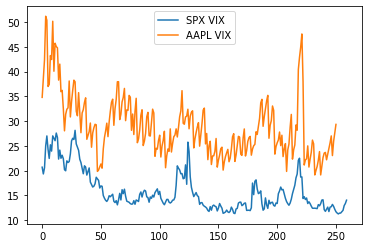

In [98]:
# plotting compared to regular vix
vix = pd.read_csv("^VIX.csv")
vix = vix[["Date", "Close"]].dropna()
vix = vix.drop(42)
vix.head()

vix["Close"].plot()
df["VIX"].plot()
plt.legend(["SPX VIX", "AAPL VIX"])